In this notebook we make a small study with a single step of the $\chi^2$ loss function for the reweighting algorithm. We see how, for a one dimensional sample, the distributions grow closer. Then, we check how they look after performing multiple steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hep_ml import reweight

import seaborn as sbs

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
font_size = 24

np.random.seed(2210)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from hep_ml.metrics_utils import ks_2samp_weighted

In [3]:
a = np.random.gamma(3,1,size=100000)
b = np.random.normal(loc=1.5,size=100000)

In [4]:
def xi(x):
    return (len(a[a<x])-len(b[b<x]))**2/(len(a[a<x])+len(b[b<x])+1)+\
           (len(a[a>=x])-len(b[b>=x]))**2/(len(a[a>=x])+len(b[b>=x])+1)

In [5]:
x = np.arange(-4.5,12,0.1)

In [6]:
fx = []
for xx in x:
    fx.append(xi(xx))
fx = np.array(fx)

In [7]:
xbest = x[np.argmax(fx)]
xbest

2.8999999999999737

In [8]:
w1 = len(b[b<xbest])/len(a[a<xbest])
w2 = len(b[b>xbest])/len(a[a>xbest])

In [9]:
w = np.where(b<xbest,w2,w1)

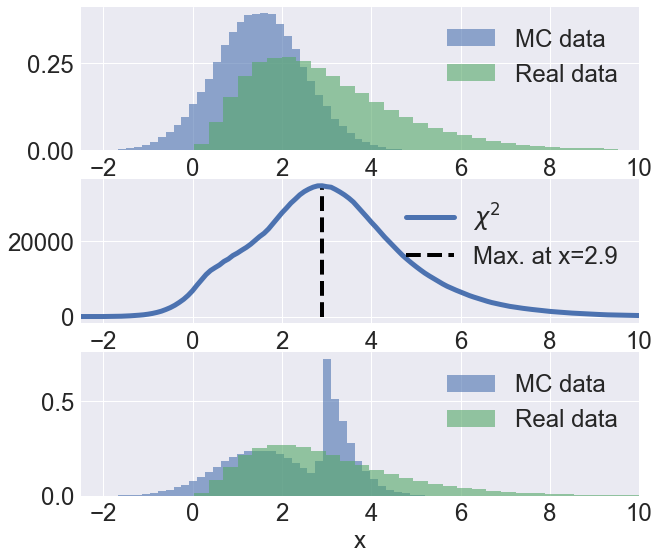

In [10]:
plt.figure(figsize=(10,9))
plt.subplot(311)
plt.hist(b,bins=50,alpha=0.6,normed=True,label="MC data")
plt.hist(a,bins=50,alpha=0.6,normed=True,label="Real data")
plt.xlim(-2.5,10)
plt.tick_params(labelsize=font_size)
plt.legend(fontsize=font_size)
plt.subplot(312)
plt.plot(x,fx,lw=5,label='$\chi^2$')
plt.vlines(xbest,fx.min(),fx.max(),lw=4,linestyles='dashed',
           label='Max. at x=2.9')
plt.xlim(-2.5,10)
plt.tick_params(labelsize=font_size)
plt.legend(fontsize=font_size)
plt.subplot(313)
plt.hist(b,bins=50,weights=w,alpha=0.6,normed=True,label="MC data")
plt.hist(a,bins=50,alpha=0.6,normed=True,label="Real data")
plt.xlim(-2.5,10)
plt.xlabel('x',fontsize=font_size)
plt.tick_params(labelsize=font_size)
plt.legend(fontsize=font_size)
plt.savefig('chi2.pdf')

We use the Kolmogorov-Smirnov metric to see how close the distributions are:

In [11]:
#before
ks_2samp_weighted(a,b,np.ones(len(a)),np.ones(len(b)))

0.38938499999858234

In [12]:
#after
ks_2samp_weighted(a,b,np.ones(len(a)),w)

0.20872630823624772

We now perform the algorithm for multiple steps.

In [13]:
gbrw = reweight.GBReweighter(n_estimators=20)

In [14]:
gbrw.fit(b,a)

GBReweighter(gb_args={}, learning_rate=0.2, max_depth=3, min_samples_leaf=200,
       n_estimators=20)

In [15]:
weights = gbrw.predict_weights(b)

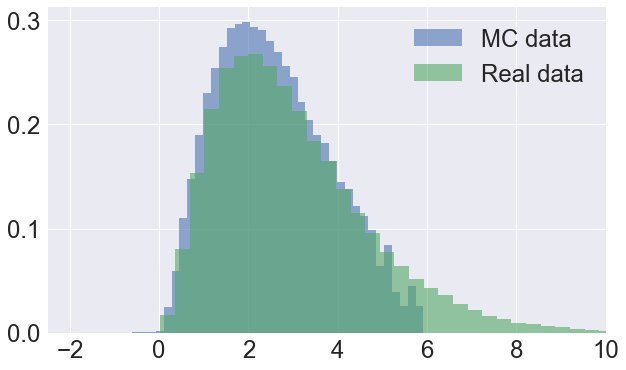

In [16]:
plt.hist(b,bins=50,weights=weights,alpha=0.6,normed=True,label="MC data")
plt.hist(a,bins=50,alpha=0.6,normed=True,label="Real data")
plt.xlim(-2.5,10)
plt.tick_params(labelsize=font_size)
plt.legend(fontsize=font_size)
plt.savefig('chifinal.pdf')

In [17]:
ks_2samp_weighted(a,b,np.ones(len(a)),weights)

0.087257033173822052

Finally, we check whether our approach was really a signle step.

In [18]:
gbrw2 = reweight.GBReweighter(n_estimators=1,learning_rate=1,max_depth=1)

In [19]:
gbrw2.fit(b,a)

GBReweighter(gb_args={}, learning_rate=1, max_depth=1, min_samples_leaf=200,
       n_estimators=1)

In [20]:
weights2 = gbrw2.predict_weights(b)

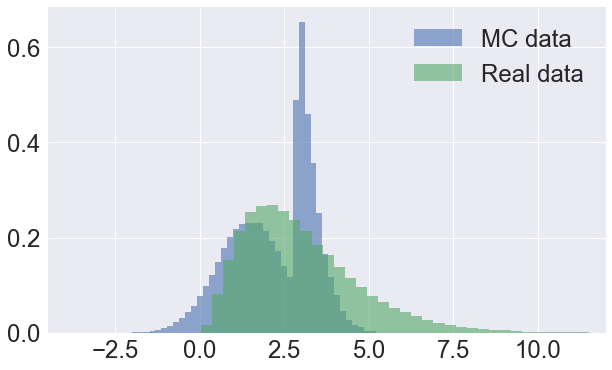

In [21]:
plt.hist(b,bins=50,weights=weights2,alpha=0.6,normed=True,label="MC data")
plt.hist(a,bins=50,alpha=0.6,normed=True,label="Real data")
plt.xlim(-4.5,12)
plt.tick_params(labelsize=font_size)
plt.legend(fontsize=font_size)

Yes, it matches our result!